# Interpretation of tree based regression (RandomForstRegressor and XGBoost)

* The aim of this use case is to use interpretation methods to check whether it has learned from the features of which it is also suspected to have learned
* To this purpose, two models (XGBoost and RandomForestRegressor) will be trained and studied using different interpretation methods (LIME, ELI5, SHAP, Partial Dependence)
* The used dataset is from the famous 'New York Taxi Fare Prediction' Kaggle competition
* The dataset with more 55 mio samples can be found here: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

## 1 - Informations to know about data / Preprocessing 

In [1]:
# process not on GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

### 1.1 - Load packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import xgboost as xgb

### 1.2 Get the data

In [3]:
data = pd.read_csv('nyc_taxi_data.csv', nrows = 1000000)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
key                  1000000 non-null object
fare_amount          1000000 non-null float64
pickup_datetime      1000000 non-null object
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999990 non-null float64
dropoff_latitude     999990 non-null float64
passenger_count      1000000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [5]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [6]:
data.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.008740,-0.007676,0.009644,-0.007629,0.012801
pickup_longitude,0.008740,1.000000,-0.529033,0.786037,-0.638188,0.000023
pickup_latitude,-0.007676,-0.529033,1.000000,-0.725437,0.455654,-0.001138
dropoff_longitude,0.009644,0.786037,-0.725437,1.000000,-0.511984,0.000680
dropoff_latitude,-0.007629,-0.638188,0.455654,-0.511984,1.000000,-0.000194
passenger_count,0.012801,0.000023,-0.001138,0.000680,-0.000194,1.000000


### 1.3 - Convert feature 'pickup_datetime' to datetime format & remove data where pickup and dropoff location is out of NY City

In [7]:
data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

In [8]:
data['pickup_day'] = data['pickup_datetime'].apply(lambda x:x.day)
data['pickup_hour'] = data['pickup_datetime'].apply(lambda x:x.hour)
data['pickup_day_of_week'] = data['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
data['pickup_month'] = data['pickup_datetime'].apply(lambda x:x.month)
data['pickup_year'] = data['pickup_datetime'].apply(lambda x:x.year)

In [9]:
data = data[((data['pickup_longitude'] > -78) & (data['pickup_longitude'] < -70)) & #Range of NYC Long
              ((data['dropoff_longitude'] > -78) & (data['dropoff_longitude'] < -70)) & #Range of NYC Lat
              ((data['pickup_latitude'] > 37) & (data['pickup_latitude'] < 45)) & 
              ((data['dropoff_latitude'] > 37) & (data['dropoff_latitude'] < 45)) & 
              ((data['passenger_count'] > 0) & (data['passenger_count'] < 7)) &
              (data['fare_amount'] >= 0)]

### 1.4 - Calculate trip distance

In [10]:
def get_distance(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    # get distance in km
    radius_earth = 6373.0

    pickup_lat = math.radians(pickup_lat)
    pickup_long = math.radians(pickup_long)
    dropoff_lat = math.radians(dropoff_lat)
    dropoff_long = math.radians(dropoff_long)
    
    distance_long = np.absolute(dropoff_long - pickup_long)
    distance_lat = np.absolute(dropoff_lat - pickup_lat)
    
    a = math.sin(distance_lat / 2)**2 + math.cos(pickup_lat) * math.cos(dropoff_lat) * math.sin(distance_long / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    return radius_earth*c

In [11]:
data['trip_distance']=data.apply(lambda row:get_distance(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

### 1.5 - Encode day into numbers from 0-6

In [12]:
def encodeDays(day_of_week):
    day_dict={'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}
    return day_dict[day_of_week]

In [13]:
data['pickup_day_of_week']=data['pickup_day_of_week'].apply(lambda x:encodeDays(x))

### 1.6 - Check for null values

In [14]:
data.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
pickup_day            0
pickup_hour           0
pickup_day_of_week    0
pickup_month          0
pickup_year           0
trip_distance         0
dtype: int64

In [15]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,trip_distance
count,975976.000000,975976.000000,975976.000000,975976.000000,975976.000000,975976.000000,975976.000000,975976.000000,975976.000000,975976.000000,975976.000000,975976.000000
mean,11.342422,-73.975198,40.750938,-73.974298,40.751279,1.690979,15.692124,13.509515,3.039496,6.270189,2011.739634,3.355471
std,9.758516,0.043640,0.033736,0.042442,0.036852,1.306098,8.682323,6.511771,1.949781,3.437367,1.866097,4.197120
min,0.000000,-77.902484,37.239032,-77.816634,37.237828,1.000000,1.000000,0.000000,0.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992273,40.736563,-73.991573,40.735569,1.000000,8.000000,9.000000,1.000000,3.000000,2010.000000,1.254444
50%,8.500000,-73.982082,40.753405,-73.980590,40.753868,1.000000,16.000000,14.000000,3.000000,6.000000,2012.000000,2.154192
75%,12.500000,-73.968308,40.767578,-73.965312,40.768417,2.000000,23.000000,19.000000,5.000000,9.000000,2013.000000,3.921888
max,500.000000,-70.140793,43.183332,-70.050500,44.600000,6.000000,31.000000,23.000000,6.000000,12.000000,2015.000000,424.966472


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975976 entries, 0 to 999999
Data columns (total 14 columns):
key                   975976 non-null object
fare_amount           975976 non-null float64
pickup_datetime       975976 non-null datetime64[ns]
pickup_longitude      975976 non-null float64
pickup_latitude       975976 non-null float64
dropoff_longitude     975976 non-null float64
dropoff_latitude      975976 non-null float64
passenger_count       975976 non-null int64
pickup_day            975976 non-null int64
pickup_hour           975976 non-null int64
pickup_day_of_week    975976 non-null int64
pickup_month          975976 non-null int64
pickup_year           975976 non-null int64
trip_distance         975976 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(6), object(1)
memory usage: 111.7+ MB


In [17]:
data = data.drop(['key','pickup_datetime'],axis = 1)

In [18]:
data.shape

(975976, 12)

In [19]:
x_data = data.drop('fare_amount', axis = 1)
y_target = data['fare_amount']

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x_data,y_target, test_size=0.25,random_state=42)

## 2.0 - Train XGBoost model and predict

In [21]:
d_train = xgb.DMatrix(x_train,label=y_train)
d_test = xgb.DMatrix(x_test,label=y_test)

In [22]:
xgb_param = {'objective':'reg:linear','eval_metric':'rmse'}
xgb_cv=xgb.cv(xgb_param, d_train, num_boost_round=5000, nfold=5,early_stopping_rounds=20)

[17:02:56] WARNING: src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:57] WARNING: src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:57] WARNING: src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:57] WARNING: src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.
[17:02:58] WARNING: src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.


In [23]:
nrounds=xgb_cv.shape[0]

In [24]:
xgb_model=xgb.train(params={'objective':'reg:linear','eval_metric':'rmse'}
                    ,dtrain=d_train,num_boost_round=nrounds)

[17:06:26] WARNING: src/objective/regression_obj.cu:148: reg:linear is now deprecated in favor of reg:squarederror.


In [25]:
xgb_train_rmse=np.sqrt(mean_squared_error(xgb_model.predict(d_train),y_train))
print('xgboost training rmse: ', xgb_train_rmse)

xgboost training rmse:  3.1289144658571453


In [26]:
xgb_pred=xgb_model.predict(d_test)
xgb_rmse=np.sqrt(mean_squared_error(xgb_pred, y_test))
print("xgboost test rmse: ",xgb_rmse)

xgboost test rmse:  3.883368199161199


In [27]:
def clean(serie):
    output = serie[(np.isnan(serie) == False) & (np.isinf(serie) == False)]
    return output

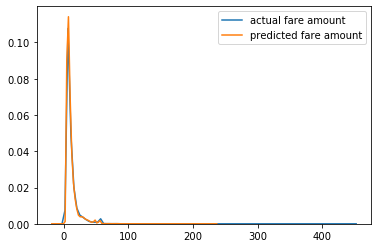

In [28]:
sns.kdeplot(clean(y_test),label='actual fare amount')
sns.kdeplot(clean(xgb_pred),label='predicted fare amount')

## 3 - Interpretability of XGBoost

### 3.1 - Generate Explanations with ELI5 framework

* ELI5 provides two methods to 'interpret' XGBoost called 'explain_weights_xgboost' and 'explain_prediction_xgboost'
* explain_weights_xgboost computes the global importance of features (feature weights)
* The feature weights are computet by following decision paths in trees of an ensemble. Each node of the tree has an output score, and contribution of a feature on the decision path is how much the score changes from parent to child.
* explain_prediction_xgboost() creates explanations for predictions by showing feature contributions
* ELI5 documentation: https://eli5.readthedocs.io/en/latest/

In [29]:
#show model weights
import eli5
eli5.explain_weights_xgboost(xgb_model)

Weight,Feature
0.7436,trip_distance
0.0941,pickup_year
0.0332,dropoff_longitude
0.0242,pickup_longitude
0.0237,dropoff_latitude
0.0217,pickup_latitude
0.0164,pickup_hour
0.0135,pickup_day_of_week
0.0135,pickup_month
0.0092,pickup_day


In [30]:
# show feature effects for prediction of one sample
eli5.explain_prediction_xgboost(xgb_model, doc = x_test[1:2],feature_names=x_test.columns.to_list(), is_regression=True)
# highest contribution/impact has feature 'trip_distance', but negative

Explanation(estimator='<xgboost.core.Booster object at 0x7fc4982db240>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=10.848362379662861, std=None, value=1.0), FeatureWeight(feature='dropoff_latitude', weight=0.2838844052427694, std=None, value=40.721327), FeatureWeight(feature='dropoff_longitude', weight=0.1967359382427776, std=None, value=-73.987893), FeatureWeight(feature='pickup_month', weight=0.06779283495530464, std=None, value=10.0), FeatureWeight(feature='pickup_longitude', weight=0.058758946471172795, std=None, value=-73.999153), FeatureWeight(feature='pickup_day', weight=0.03353691232192525, std=None, value=20.0)], neg=[FeatureWeight(feature='trip_distance', weight=-5.495441901736001, std=None, value=0.9604644884492413), FeatureWeight(feature='pickup_year', weight=-0.33528968089450295, std=None, value=2010.0), FeatureWeight(feature='pickup_hour', weight=-0.22116424463804274, std=None, value=21.0), FeatureWeight(feature='pickup_latitude', weight=-0.1649596483087002, std=None, value=40.722645), FeatureWeight(feature='pickup_day_of_week', weight=-0.13985915669031967, std=None, value=2.0), FeatureWeight(feature='passenger_count', weight=-0.04928145130365951, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=None, score=5.083075333325585, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [31]:
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(xgb_model).fit(x_test.as_matrix(),y_test.as_matrix())
eli5.show_weights(perm, feature_names=list(x_test))

#-----> does not work for xgboost, because XGBoost does not implement any fit method

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


TypeError: estimator should be an estimator implementing 'fit' method, <xgboost.core.Booster object at 0x7fc4982db240> was passed

### 3.2 - Generate Explanations with LIME

In [32]:
import lime
import lime.lime_tabular

In [33]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train), feature_names=x_train.columns.to_list(), class_names=['fare_amount'], mode='regression')

In [34]:
# explain_instance() -> predict and explain
d_test = xgb.DMatrix(x_test[0:1],label=y_test[0:1])
exp = explainer.explain_instance(d_test, xgb_model.predict,num_features=5)
# LIME seems to not work with XGBoost, because it cannot process dmatrices

AttributeError: 'DMatrix' object has no attribute 'shape'

* LIME does not generate any explanations for XGBoost, becuase it can not generate any data for prediction (perturbation) -> XGBoost uses 'train'; LIME uses a fit method

### 3.3 Generate Explanations with SHAP frame work

* SHAP provides a method called 'TreeExplainer' to estimate Shap values for tree models and ensembles of trees, under several different possible assumptions about feature dependence. 
* TreeExplainer is compatible with XGBoost

In [35]:
import shap

In [36]:
shap_explainer = shap.TreeExplainer(xgb_model)

In [37]:
shap_values = shap_explainer.shap_values(x_test)

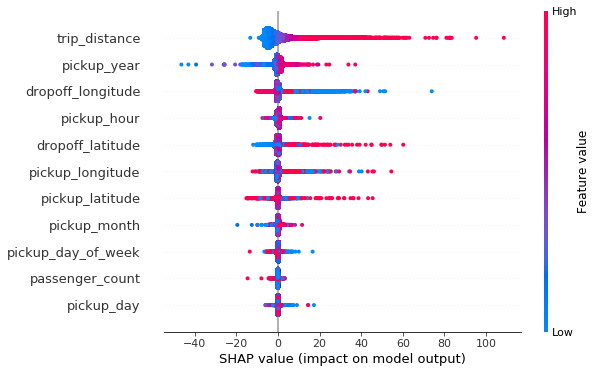

In [38]:
shap.summary_plot(shap_values, x_test)
# the higher the trip distance is, the higher is the model output (as expected)

### 3.4 - Generate Partial Dependence Plots with sklearn.inspection

* A partial dependence plot can show whether the relationship between the target variable (fare_amount) and a feature (trip_distance in this case) is linear, monotonic or more complex

In [39]:
#from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from sklearn.inspection.partial_dependence import partial_dependence, plot_partial_dependence
plot_partial_dependence(xgb_model, features=[0,2], X =  x_test, feature_names = x_train.columns.to_list())
# does not work with xgboost !!!

ValueError: 'estimator' must be a fitted regressor or classifier.

* Partial Dependence Plots cannot be generated for XGBoost, because XGBoost it is not scikit-compatible. You can use XGBRegressor.fit instead. 
* You can take a look here, to see the difference between XGBoost and XGBoostRegressor (and diff. between train and fit): https://www.kaggle.com/questions-and-answers/65417

### 4 - Train RandomForestRegressor model and predict

In [40]:
random_forest = RandomForestRegressor(n_estimators = 50, random_state = 142, max_depth=5,n_jobs=-1)
random_forest.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=142, verbose=0,
                      warm_start=False)

In [41]:
rf_train_rmse=np.sqrt(mean_squared_error(random_forest.predict(x_train),y_train))
print('xgboost training rmse: ', rf_train_rmse)

xgboost training rmse:  4.5751858919854715


In [42]:
rf_pred = random_forest.predict(x_test)

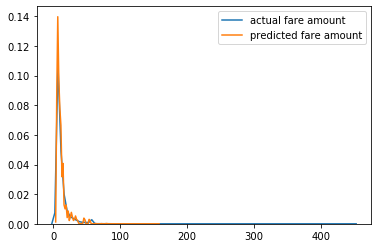

In [43]:
sns.kdeplot(clean(y_test),label='actual fare amount')
sns.kdeplot(clean(rf_pred),label='predicted fare amount')

### 5 - Interpretability of RandomForestRegressor 

### 5.1 Generate explanations with ELI5 framework

In [44]:
import eli5
eli5.explain_weights(random_forest,feature_names = x_test.columns.to_list())

Weight,Feature
0.9424 ± 0.0082,trip_distance
0.0246 ± 0.0118,dropoff_longitude
0.0229 ± 0.0025,pickup_year
0.0088 ± 0.0085,pickup_longitude
0.0011 ± 0.0041,dropoff_latitude
0.0001 ± 0.0021,pickup_month
0.0001 ± 0.0009,pickup_day_of_week
0 ± 0.0000,pickup_hour
0 ± 0.0000,pickup_day
0 ± 0.0000,passenger_count


In [45]:
print('Predicted taxi fare: ',random_forest.predict(x_test[2:3]))

Predicted taxi fare:  [5.57675204]


In [46]:
eli5.show_weights(random_forest)

Weight,Feature
0.9424 ± 0.0082,x10
0.0246 ± 0.0118,x2
0.0229 ± 0.0025,x9
0.0088 ± 0.0085,x0
0.0011 ± 0.0041,x3
0.0001 ± 0.0021,x8
0.0001 ± 0.0009,x7
0 ± 0.0000,x6
0 ± 0.0000,x5
0 ± 0.0000,x4


In [47]:
# show feature effects for prediction of one sample
eli5.explain_prediction(random_forest, doc = x_test[2:3],feature_names=x_test.columns.to_list())

Explanation(estimator="RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,\n                      max_features='auto', max_leaf_nodes=None,\n                      min_impurity_decrease=0.0, min_impurity_split=None,\n                      min_samples_leaf=1, min_samples_split=2,\n                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,\n                      oob_score=False, random_state=142, verbose=0,\n                      warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=11.349196399092271, std=None, value=1.0)], neg=[FeatureWeight(feature='trip_distance', weight=-5.769630476953154, std=None, value=1.150934873525116), FeatureWeight(feature='pickup_longitude', weight=-0.0028138828350049217, std=None, value=-73.978063)], pos_remaining=0, neg_remaining=0), proba=None, score=5.576752039304108, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

* The bias term can be understanded as the expected average score output of the model. 
* y = BIAS +/- feature contribution

In [48]:
#x=lambda feature_names: feature_names != '<BIAS>'
#eli5.explain_prediction(random_forest, doc = x_test[2:3],feature_names=x_test.columns.to_list(),feature_filter=x_test.columns.to_list())

### 5.2 Generate Explanations with LIME

* Lime advertises that it is suitable for all classifiers, but it also offers a 'regression mode'
* In 'regression' mode, LimeTabularExplainer() can generate explanations for a RandomForestRegressor() model

In [49]:
import lime
import lime.lime_tabular

In [50]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train), feature_names=x_train.columns.to_list(), class_names=['fare_amount'], mode='regression')

In [51]:
exp = explainer.explain_instance(x_train.values[1], random_forest.predict)

In [52]:
exp.show_in_notebook()

### 5.3 Generate Explanations with SHAP

* SHAP provides a method called 'TreeExplainer' to estimate Shap values for tree models and ensembles of trees, under several different possible assumptions about feature dependence. 
* TreeExplainer ist compatible with scikit-learn's RandomForestRegressor()

In [53]:
import shap

In [54]:
shap_explainer = shap.TreeExplainer(random_forest)

In [55]:
shap_values = shap_explainer.shap_values(x_test)

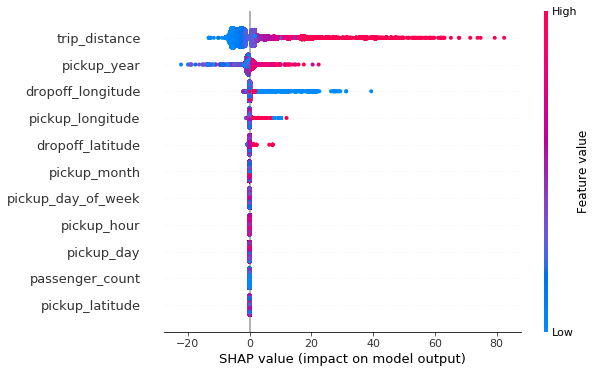

In [56]:
shap.summary_plot(shap_values, x_test)

### 5.4 Generate Partial Dependence Plots with sklearn.inspection

* A partial dependence plot can show whether the relationship between the target variable (fare_amount in this case) and a feature (trip_distance in this case) is linear, monotonic or more complex

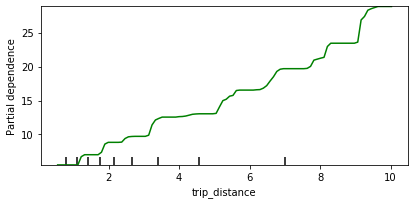

In [57]:
from sklearn.inspection.partial_dependence import partial_dependence, plot_partial_dependence
plot_partial_dependence(random_forest, features=[10], X = x_test, feature_names = x_test.columns.to_list())